# Seattle Crime #

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
import time

ModuleNotFoundError: No module named 'catboost'

In [2]:
start_time = time.time()

## Opening Datafile ##

In a separate notebook, we preprocessed our "SPD_Crime_Data" file, and saved it as a new CSV file. We'll now open that file to use for our models.

In [3]:
df = pd.read_csv("preprocessed_data.csv")
df.head()

,Unnamed: 0,Crime Against Category,Offense,Sector,Beat,MCPP,Time,Day,Year
0,1,2,Theft of Motor Vehicle Parts or Accessories,11,22,50,661,0,0
1,2,2,Robbery,22,50,50,1753,6,0
2,3,2,Destruction/Damage/Vandalism of Property,18,39,33,124,2,0
3,5,2,Shoplifting,14,29,16,2005,1,0
4,6,2,Destruction/Damage/Vandalism of Property,11,22,44,1753,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210259 entries, 0 to 210258
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unnamed: 0              210259 non-null  int64 
 1   Crime Against Category  210259 non-null  int64 
 2   Offense                 210259 non-null  object
 3   Sector                  210259 non-null  int64 
 4   Beat                    210259 non-null  int64 
 5   MCPP                    210259 non-null  int64 
 6   Time                    210259 non-null  int64 
 7   Day                     210259 non-null  int64 
 8   Year                    210259 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 14.4+ MB


## Setting Up For Initial Model ##

Let's start off by first identifying our target variable

In [5]:
X = df.drop("Offense", axis = 1)

#Target Variable
y = df["Offense"]

Now we'll split our data using Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

We'll scale our data, to make it easier for the model to work with

In [7]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

Let's look at the value counts for our dependent variable

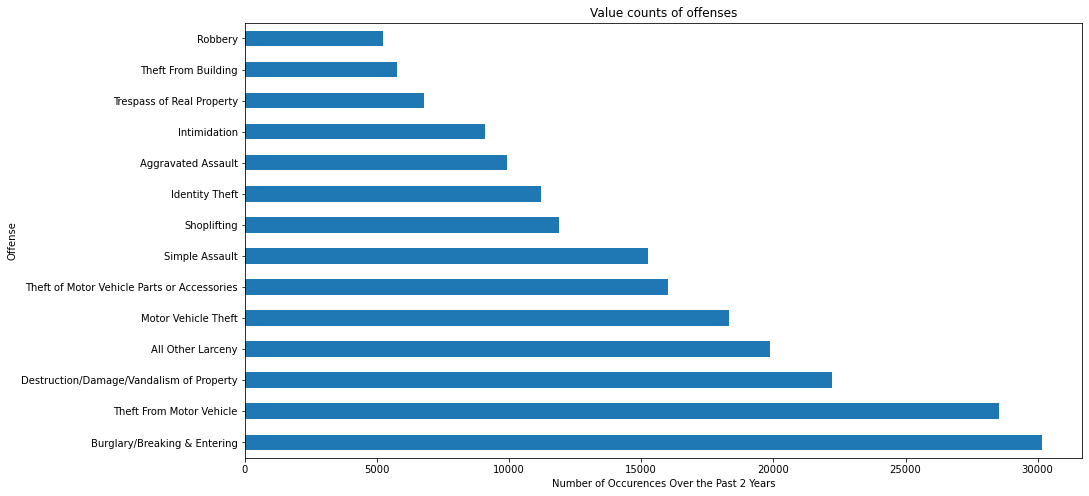

In [8]:
ax = df.value_counts('Offense').plot.barh(figsize = (15,8), title = "Value counts of offenses");
ax.set_xlabel("Number of Occurences Over the Past 2 Years");

We can see that there's an imbalance, so let's use SMOTE to address that

In [9]:
sm = SMOTE(random_state = 1)
X_train, y_train = sm.fit_sample(X_train, y_train)

Now it's time to initialize our model

## Random Forest Model ##

In [10]:
#rf = RandomForestClassifier(criterion= "entropy",random_state = 1,  max_depth = 5)

#rf.fit(X_train, y_train)
#rf_train_pred = rf.predict(X_train)
#rf_test_pred = rf.predict(X_test)

In [11]:
#print(classification_report(y_train, rf_train_pred))

In [12]:
#print(classification_report(y_test, rf_test_pred))

In [13]:
#fig, ax = plt.subplots(figsize=(15,15))
#interp.plot_confusion_matrix(rf, X_test, y_test);

#np.interp.plot_confusion_matrix(figsize=(10,10))

#cm = confusion_matrix(y_test, rf_test_pred);
#cmp = ConfusionMatrixDisplay(cm);
#fig, ax = plt.subplots(figsize=(13,13));
#cmp.plot(ax=ax);
#cmp.ax_.set_title("Confusion Matrix");

0) Aggravated Assault

1) All Other Larceny

2) Burglary/Breaking & Entering

3) Destruction/Damage/Vandalism of Property

4) Intimidation

5) Motor Vehicle Theft

6) Shoplifting

7) Simple Assault

8) Theft From Motor Vehicle

9) Theft of Motor Vehicle Parts or Accessories


### Crime Confusion Matrix ###

**0) Aggravated Assault**

* 615 crimes were correctly predicted as being "aggravated assault" crimes
* 1,225 crimes were wrongly predicted as not being "aggravated assault" crimes
* 1,030 crimes were wrongly predicted as being "aggravated assault" crimes
* 28,976 crimes were correctly predicted as not being "aggravated assault" crimes

**1) All Other Larceny**

* 578 crimes were correctly predicted as being "all other larceny" crimes
* 2,834 crimes were wrongly predicted as not being "all other larceny" crimes
* 2,389 crimes were wrongly precicted as being "all other larceny" crimes
* 26,045 crimes were correctly predicted as not being "all other larceny" crimes

**2) Burglary/Breaking & Entering**

* 1799 crimes were correctly predicted as being "burglary/breaking & entering" crimes
* 3,096 crimes were wrongly predicted as not being "burglary/breaking & entering" crimes
* 4,414 crimes were wrongly predicted as being "burglary/breaking & entering" crimes
* 23,722 crimes were correctly predicted as not being "burglary/breaking & entering" crimes

**3) Destruction/Damage/Vandalism of Property**

* 283 crimes were correctly predicted as being "destruction/damage/vandalism of property" crimes
* 3,579 crimes were wrongly predicted as not being "destruction/damage/vandalism of property" crimes
* 891 crimes were wrongly predicted as being "destruction/damage/vandalism of property" crimes
* 28,942 crimes were correctly predicted as not being "destruction/damage/vandalism of property" crimes

**4) Intimidation**

* 846 crimes were correctly predicted as being "intimidation" crimes
* 713 crimes were wrongly predicted as not being "intimidation" crimes
* 1,748 crimes were wrongly predicted as being "intimidation" crimes
* 29, 559 crimes were correctly predicted as not being "intimidation" crimes

**5) Motor Vehicle Theft**

* 796 crimes were correctly predicted as being "motor vehicle theft" crimes
* 2,548 crimes were wrongly predicted as not being "motor vehicle theft" crimes
* 3,583 crimes were wrongly predicted as being "motor vehicle theft" crimes
* 27,841 crimes were correctly predicted as not being "motor vehicle theft" crimes

**6) Shoplifting**

* 1559 crimes were correctly predicted as being "shoplifting" crimes
* 424 crimes were wrongly predicted as not being "shoplifting" crimes
* 7,522 crimes were wrongly predicted as being "shoplifting" crimes
* 27,652 crimes were correctly predicted as not being "shoplifting" crimes

**7) Simple Assault**

* 853 crimes were correctly predicted as being "simple assault" crimes
* 1,758 crimes were wrongly predicted as not being "simple assault" crimes
* 918 crimes were wrongly predicted as being "simple assault" crimes
* 30,993 crimes were correctly predicted as not being "simple assault" crimes

**8) Theft From Motor Vehicle**

* 244 crimes were correctly predicted as being "theft from motor vehicle" crimes
* 4,651 crimes were wrongly predicted as not being "theft from motor vehicle" crimes
* 549 crimes were wrongly predicted as being "theft from motor vehicle" crimes
* 31,282 crimes were correctly predicted as not being "theft from motor vehicle" crimes

**9)  Theft of Motor Vehicle Parts or Accessories**

* 244 crimes were correctly predicted as being "theft of motor vehicle parts or accessories" crimes
* 3,021 crimes were wrongly predicted as not being "theft of motor vehicle parts or accessories" crimes
* 985 crimes were wrongly predicted as not being "theft of motor vehicle parts or accessories" crimes
* 26,966 crimes were correctly predicted as not being "theft of motor vehicle parts or accessories" crimes

### Crime Classification Report ###

## Random Forest Tuning ##

In [14]:
#rf2 = RandomForestClassifier()

#param_grid = {
   # 'criterion': ['entropy'],
   # 'random_state': [1],
   # 'max_depth': [1, 2, 3, 4, 5],
   # 'min_samples_split': [0.2, 0.25, 0.3, 0.35, 0.4 ],
   # 'min_samples_leaf': [0.1, 0.2, 0.3]
#}


#gs_rf = GridSearchCV(rf2, param_grid)
#gs_rf.fit(X_train, y_train)
#gs_rf.best_params_

In [15]:
#gs_forest_train_pred = gs_rf.predict(X_train)
#print(classification_report(y_train, gs_forest_train_pred))

In [16]:
#gs_forest_test_pred = gs_rf.predict(X_test)
#print(classification_report(y_test, gs_forest_test_pred))

In [17]:
#rf3 = RandomForestClassifier()

#param_grid2 = {
   # 'criterion': ['entropy'],
   # 'random_state': [1],
   # 'max_depth': [2, 3, 4],
    #'min_samples_split': [0.24, 0.25, 0.26],
   # 'min_samples_leaf': [0.1, 0.12, 0.13]
#}


#gs_rf2 = GridSearchCV(rf2, param_grid)
#gs_rf2.fit(X_train, y_train)
#gs_rf2.best_params_

In [18]:
#rf4 = RandomForestClassifier(criterion= "entropy", random_state = 1,  max_depth = 3, min_samples_split= 0.2, min_samples_leaf = 0.1,  )

#rf4.fit(X_train, y_train)
#rf_train_pred2 = rf4.predict(X_train)
#rf_test_pred2 = rf4.predict(X_test)

In [19]:
#cm2 = confusion_matrix(y_test, rf_test_pred2);
#cmp2 = ConfusionMatrixDisplay(cm2);
#fig, ax = plt.subplots(figsize=(13,13));
#cmp2.plot(ax=ax);
#cmp2.ax_.set_title("Confusion Matrix");

In [20]:
#print(classification_report(y_train, rf_train_pred2))

In [21]:
#print(classification_report(y_test, rf_test_pred2))

In [22]:
#print ("My program took", time.time() - start_time, "to run")

## CatBoost Model ##

In [23]:
model = CatBoostClassifier(
    random_state = 1,
    loss_function = 'MultiClass',
)

NameError: name 'CatBoostClassifier' is not defined